In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, math
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace
from tqdm.notebook import tqdm
import torch 
from torch.utils.data import DataLoader

sys.path.append('../')
from utils.arg_parser import parse_exp_args
from utils.common import PlainDataset
from run import load_model

## Set options

In [3]:
# runid = 'fc_delta_full_pinj'
runid = 'cnn_delta_full_pinj'

dataset = 'cnn_delta_full_pinj'

ep = 730
plot_train = True
device = 'cuda:7'
train_batch = 1024
# device = 'cpu'

In [4]:
pred_dir = '/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/{}'.format(runid)
data_dir = '/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/data/{}'.format(dataset)

print(pred_dir)
print(data_dir)

/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/cnn_delta_full_pinj
/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/data/cnn_delta_full_pinj


### Load test points, and train points/model

In [5]:
test_preds = np.load(os.path.join(pred_dir, 'test_preds_ep_{}.npy'.format(ep)))
test_X = np.load(os.path.join(data_dir, 'test_X.npy'))
test_y = np.load(os.path.join(data_dir, 'test_y.npy'))
print('loaded test predictions and gt')
print(test_preds.shape, test_y.shape)
num_test = test_y.shape[0]

if plot_train:
    train_X = np.load(os.path.join(data_dir, 'train_X.npy'))
    train_y = np.load(os.path.join(data_dir, 'train_y.npy'))
    print('loaded train data')
    print(train_X.shape, train_y.shape)
    num_train = train_y.shape[0]

loaded test predictions and gt
(17327, 1) (17327, 1)
loaded train data
(156664, 12, 100) (156664, 1)


### (optional) see which test predictions are non zero

In [6]:
non_zero = []
for i in range(test_preds.shape[0]):
    if test_preds[i] != 0:
        non_zero.append(i)
non_zero = np.array(non_zero)
print(non_zero)
print(test_preds[non_zero])
print(test_preds[non_zero].min())

[    0     1     2 ... 17324 17325 17326]
[[-0.00099245]
 [ 0.0119178 ]
 [-0.03763652]
 ...
 [-0.4608299 ]
 [-0.44441652]
 [-0.42770705]]
-3.4766226


## load test model

In [6]:
if plot_train:
    args_file = os.path.join(pred_dir, 'args.txt')
    model_path = os.path.join(pred_dir, 'model_ep_{}'.format(ep))
    temp_args = parse_exp_args(args_file)
    temp_args.multi_gpu = False
    temp_args.device = device
    temp_args.model_path = model_path
#     temp_args = Namespace(model_path=model_path,
#                           device=device,
#                           multi_gpu=False)
    test_model = load_model(temp_args)
    test_model.eval()
    print('loaded model')
    train_dataset = PlainDataset(None, None, False, X_arr=train_X, y_arr=train_y)
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=False)

Loading model from /home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/cnn_delta_full_pinj/model_ep_730
input to conv1D of 12 channels * 100 signal length (1200 values)
output of conv1D of 10 channels * 91 signal length (910 values), actv None
output of conv1D of 5 channels * 87 signal length (435 values), actv None
output of conv1D of 5 channels * 83 signal length (415 values), actv None
output of conv1D of 5 channels * 82 signal length (410 values), actv None
output of linear layer of 256 values, actv relu
output of linear layer of 256 values, actv relu
output of linear layer of 128 values, actv relu
output of linear layer of 1 values, actv None
ModuleList(
  (0): Conv1DLayer(
    (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Conv1DLayer()
  (2): Conv1DLayer(
    (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Conv1DLayer()
  (4): LinearLayer(
    (bn): BatchNorm1d(256, eps=1e-0

In [8]:
list(test_model.named_parameters())

[('layers.0.weight',
  Parameter containing:
  tensor([[[ 0.0204, -0.0436,  0.0217,  ..., -0.0297, -0.0409, -0.0539],
           [-0.0026, -0.0208,  0.0050,  ...,  0.0262,  0.0184, -0.0149],
           [ 0.0004,  0.0536,  0.0402,  ..., -0.0168, -0.0140,  0.0198],
           ...,
           [-0.0377, -0.0364,  0.0220,  ..., -0.0482, -0.0384, -0.0475],
           [ 0.0504,  0.0043, -0.0145,  ...,  0.0523, -0.0308,  0.0518],
           [-0.0046, -0.0078,  0.0360,  ...,  0.0034, -0.0381,  0.0014]],
  
          [[-0.0345, -0.0178, -0.0072,  ..., -0.0167,  0.0456, -0.0431],
           [-0.0419, -0.0007, -0.0165,  ...,  0.0288, -0.0238, -0.0496],
           [ 0.0065, -0.0174,  0.0289,  ..., -0.0408, -0.0247,  0.0271],
           ...,
           [-0.0428, -0.0225, -0.0177,  ..., -0.0401,  0.0339, -0.0217],
           [ 0.0008, -0.0480,  0.0250,  ...,  0.0408, -0.0120,  0.0158],
           [-0.0408, -0.0235, -0.0379,  ...,  0.0164, -0.0549, -0.0113]],
  
          [[-0.0369, -0.0436,  0.0424, 

### Get training points

In [7]:
if plot_train:
    print('getting train predictions now')
    train_pred_list = []
    print('total iterations {}'.format(math.ceil(num_train/train_batch)))
    for idx, (curr_X, _) in tqdm(enumerate(train_loader)):
        with torch.no_grad():
            curr_X = curr_X.to(device)
            curr_preds = test_model(curr_X)
            train_pred_list.append(curr_preds.cpu().numpy())
    train_preds = np.concatenate(train_pred_list, axis=0)
    print(train_preds.shape)

getting train predictions now
total iterations 153



(156664, 1)


### check difference in test preds and test_model output on test_X are same

In [8]:
temp = test_model(torch.FloatTensor(test_X).to(device))
test_diff = temp.detach().cpu().numpy() - test_preds
print(test_diff.max(), test_diff.min())

0.0 0.0


## Sort outputs for plot

In [9]:
test_y_order = np.argsort(test_y, axis=0).flatten()
print(test_y_order)
if plot_train:
    train_y_order = np.argsort(train_y, axis=0).flatten()
    print(train_y_order)

[ 2418 13513 13514 ... 13520 13523 13525]
[130013   3117  67259 ...  67258 113258 130003]


In [10]:
sorted_test_preds = test_preds[test_y_order]
sorted_test_y = test_y[test_y_order]
if plot_train:
    sorted_train_preds = train_preds[train_y_order]
    sorted_train_y = train_y[train_y_order]

### Plot test performance

MSE: 0.222218


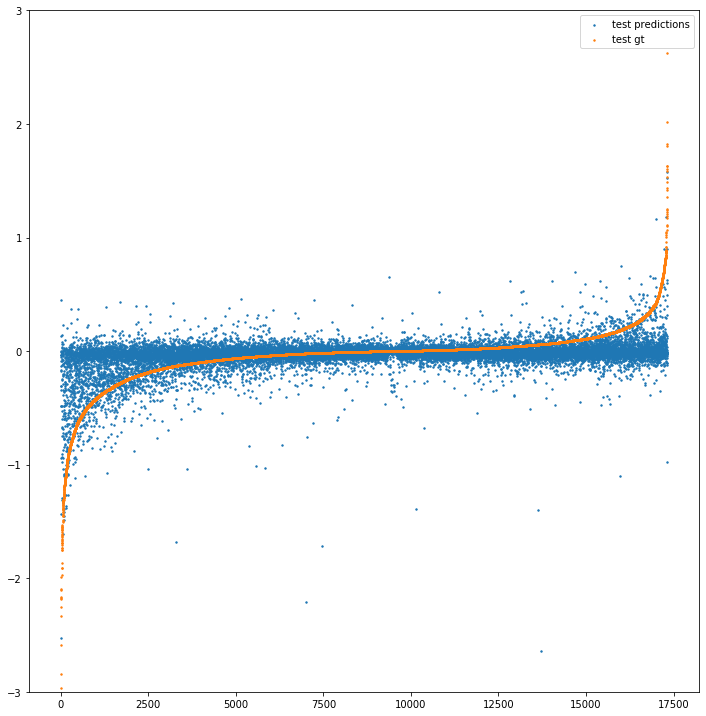

In [11]:
plt.scatter(np.arange(num_test), sorted_test_preds, label='test predictions', s=2)
plt.scatter(np.arange(num_test), sorted_test_y, label='test gt', s=2)

curr_MSE = np.mean((sorted_test_preds - sorted_test_y)**2)
print('MSE: {0:.6f}'.format(curr_MSE))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,10)

# # first 1000
# plt.xlim(0,1000)
# last 100
# plt.xlim(num_test-1000, num_test)
fig.tight_layout()
# fig.autoscale()
plt.ylim(-3,3)

plt.show()

In [12]:
test_preds.min(), test_preds.max()

(-19.975662, 1.5792526)

MSE: 0.0680899771


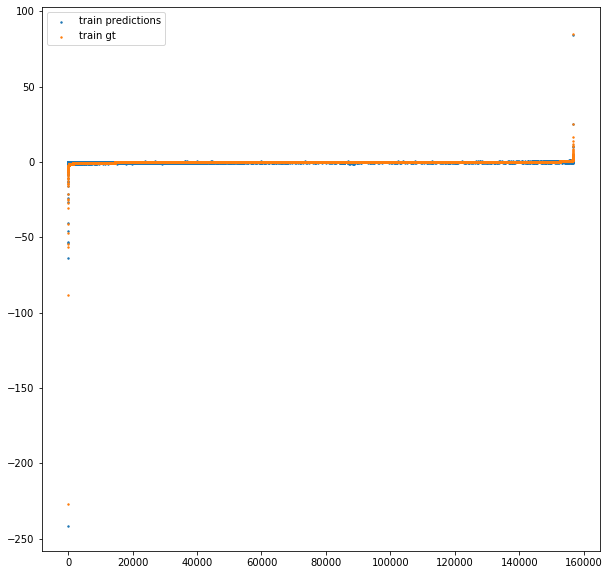

In [14]:
plt.scatter(np.arange(num_train), sorted_train_preds, label='train predictions', s=2)
plt.scatter(np.arange(num_train), sorted_train_y, label='train gt', s=2)
curr_MSE = np.mean((sorted_train_preds - sorted_train_y)**2)
print('MSE: {0:.10f}'.format(curr_MSE))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,10)

# # first 100
# plt.xlim(0,100)
# last 100
# plt.xlim(num_train-100, num_train)
# plt.ylim(-1.2, 1.2)

plt.show()

In [19]:
sorted_train_preds.min()

-1.1218371

In [27]:
list(test_model.named_parameters())[-5]

('layers.6.bias',
 Parameter containing:
 tensor([ 0.0213, -0.0067,  0.0452, -0.0600, -0.0035,  0.0562,  0.0042, -0.0331,
         -0.0360, -0.0429,  0.0556, -0.0068, -0.0403,  0.0587, -0.0467,  0.0435,
         -0.0456, -0.0419,  0.0231,  0.0284, -0.0254,  0.0162, -0.0034, -0.0641,
         -0.0215, -0.0138,  0.0129,  0.0235,  0.0583, -0.0394, -0.0557, -0.0063,
          0.0268, -0.0453, -0.0430, -0.0197, -0.0098,  0.0292, -0.0293, -0.0382,
          0.0553,  0.0364, -0.0524, -0.0524, -0.0010,  0.0299, -0.0178,  0.0146,
          0.0449,  0.0399,  0.0308, -0.0389,  0.0174, -0.0480, -0.0058, -0.0277,
          0.0563, -0.0513,  0.0155,  0.0551, -0.0559, -0.0202, -0.0186,  0.0280,
          0.0142, -0.0055, -0.0636, -0.0537, -0.0417,  0.0180,  0.0041, -0.0576,
          0.0522,  0.0517,  0.0234,  0.0230, -0.0582, -0.0594,  0.0111, -0.0083,
          0.0473,  0.0145,  0.0147,  0.0064, -0.0463, -0.0499, -0.0182,  0.0157,
         -0.0230, -0.0313,  0.0228, -0.0286,  0.0594, -0.0252, -0.05

In [29]:
test_model

cnn(
  (loss): MSELoss()
  (layers): ModuleList(
    (0): Conv1DLayer(
      (pool): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv1DLayer(
      (pool): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Conv1DLayer(
      (pool): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(0,))
    )
    (3): Conv1DLayer(
      (pool): AvgPool1d(kernel_size=(2,), stride=(1,), padding=(0,))
    )
    (4): LinearLayer(
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (5): LinearLayer(
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (6): LinearLayer(
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (7): LinearLayer(
      (activation): R

In [34]:
num_out = 0
for i in train_y:
    if np.abs(i) > 3.5:
#         print(i)
        num_out += 1
print(num_out, 100*num_out/num_train)

84 0.05361793392227953


In [28]:
num_out = 0
for i in test_y:
    if np.abs(i) > 1.2:
#         print(i)
        num_out += 1
print(num_out, 100*num_out/num_train)

122 0.07787366593473931


In [16]:
test_z = (test_y - np.mean(test_y))/np.std(test_y)

In [18]:
np.sum(np.abs(test_z)>3 )/num_test

0.00554048594678825

In [24]:
test_y[np.abs(test_z)>3].size

96

In [22]:
np.abs(test_y[np.abs(test_z)>3]).min()

1.2456196956933563